In [1]:
import os
import math
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, cdist
from mpl_toolkits.mplot3d import Axes3D
import soundfile as sf
from prettytable import PrettyTable
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import hilbert, butter, filtfilt, medfilt, lfilter, wiener, convolve

In [2]:
fruit_types = ['pera', 'banana', 'manzana', 'naranja']
audios = {fruit: [] for fruit in fruit_types}
root_dir = '../../dataset'

In [3]:
for dirname, _, filenames in os.walk(root_dir):
    fruit_type = os.path.basename(dirname)
    if fruit_type in fruit_types:
        audios[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [4]:
processed = {fruit: [] for fruit in fruit_types}

for dirname, _, filenames in os.walk(root_dir):
    path = os.path.basename(dirname)
    if path == 'processed':
        fruit_type = os.path.basename(os.path.dirname(dirname))
        if fruit_type in fruit_types:
            processed[fruit_type].extend([os.path.join(dirname, filename) for filename in filenames if filename.endswith('.wav')])

In [5]:
FRAME_SIZE = 1024 # In the documentation says it's convenient for speech.C
HOP_SIZE   = int(FRAME_SIZE/2)

In [6]:
def load_audio(audiofile):
    test_audio, sr = librosa.load(audiofile, sr = None)
    duration = librosa.get_duration(filename=audiofile, sr=sr)
    return test_audio, sr, duration

In [7]:
def time_vector(signal, duration):
    return np.linspace(0, duration, len(signal))

In [8]:
def rms(signal):
    return librosa.feature.rms(y=signal, frame_length = FRAME_SIZE, hop_length = HOP_SIZE)

In [9]:
def normalize(signal):
    peak = np.max(signal)
    signal/=peak
    return signal

In [10]:
def low_pass_filter(signal, sr, cutoff_frequency = 5000):
    nyquist = 0.5 * sr
    cutoff = cutoff_frequency / nyquist
    b, a = butter(N=6, Wn=cutoff, btype='low', analog=False, output='ba')
    filtered = lfilter(b, a, signal)
    return filtered

In [11]:
def band_pass_filter(signal, sr, low_cutoff, high_cutoff):
    b, a = butter(N=3, Wn = [low_cutoff, high_cutoff], btype='band', fs=sr)
    return lfilter(b, a, signal)

In [12]:
def wiener_filter(signal, noise = 0.9):
    filtered = wiener(signal, noise = noise)
    return filtered

In [13]:
def envelope(signal):
    analytic_signal = hilbert(signal)
    return np.abs(analytic_signal)

In [14]:
def smooth_envelope(signal, sr, cutoff_frequency=50.0):
    return low_pass_filter(envelope(signal), sr, cutoff_frequency)

In [15]:
def calculate_split_frequency_bin(split_frequency, sample_rate, num_frequency_bins):
    """Infer the frequency bin associated to a given split frequency."""
    
    frequency_range = sample_rate / 2
    frequency_delta_per_bin = frequency_range / num_frequency_bins
    split_frequency_bin = math.floor(split_frequency / frequency_delta_per_bin)
    return int(split_frequency_bin)

In [16]:
def band_energy_ratio(spectrogram, split_frequency, sample_rate):
    """Calculate band energy ratio with a given split frequency."""
    
    split_frequency_bin = calculate_split_frequency_bin(split_frequency, sample_rate, len(spectrogram[0]))
    band_energy_ratio = []
    
    # calculate power spectrogram
    power_spectrogram = np.abs(spectrogram) ** 2
    power_spectrogram = power_spectrogram.T
    
    # calculate BER value for each frame
    for frame in power_spectrogram:
        sum_power_low_frequencies = frame[:split_frequency_bin].sum()
        sum_power_high_frequencies = frame[split_frequency_bin:].sum()
        band_energy_ratio_current_frame = sum_power_low_frequencies / sum_power_high_frequencies
        band_energy_ratio.append(band_energy_ratio_current_frame)
    
    return np.array(band_energy_ratio)

In [17]:
#2d
def plot_features2d(features):
    fig = plt.figure()
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))
    

    for fruit, points in features.items():
        plt.scatter(points[:, 0], points[:, 1], c = colors[fruit], label=fruit)

    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.show()

In [18]:
#3d
def plot_features3d(features):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = dict(zip(fruit_types,['green','yellow','red','orange']))

    for fruit, points in features.items():
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], c=colors[fruit], marker='o', label=fruit)
        
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.set_zlabel('Eje Z')
    plt.show()

PRIMERA APROXIMACIÓN. BASTANTE BIEN

In [25]:
# Features extraction
features = dict.fromkeys(fruit_types)
split_frequency = 3000
cuton = 20
cutoff = 8500
n_mfcc = 4

for fruit, audios in processed.items():
    features[fruit] = None
    
    for audio in audios:
        # Load the audio signal
        signal, sr, duration = load_audio(audio)

        # Empty row of features
        feature = np.empty((1, 0))

        # Calculate the rms
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)
        feat = audio_rms
        feature = np.append(feature, audio_rms)

        # BER min
        spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        BER  = band_energy_ratio(spec, split_frequency, sr)
        feat = np.min(BER)
        #feature = np.append(feature, feat)

        # Centroid
        centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        centroid /= np.max(np.abs(centroid))
        # Varnz
        feat = np.var(centroid)
        #feature = np.append(feature, feat)
        # std
        feat = np.std(centroid)/np.mean(centroid)
        feature = np.append(feature, feat)

        # Envelope RMS
        smoothed = rms(signal)
        smoothed = smoothed.reshape(-1,)
        smoothed /= np.max(np.abs(smoothed))
        # varnz
        feat = np.var(smoothed)
        #feature = np.append(feature, feat)
        #std
        feat = np.std(smoothed)/np.mean(smoothed)
        feature = np.append(feature, feat)
        #momentum
        t = time_vector(smoothed, duration)
        feat = np.dot(smoothed, t)/np.sum(smoothed)
        feature = np.append(feature, feat)

        #ZCR
        filtered = band_pass_filter(signal, sr, cuton, cutoff)
        zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        zcr /= np.max(np.abs(zcr))
        #mean
        feat = np.mean(zcr)
        feature = np.append(feature, feat)
        #maximum
        feat = np.max(zcr)
        #feature = np.append(feature, feat)
        #varnz
        feat = np.var(zcr)
        #feature = np.append(feature, feat)
        #std
        feat = np.std(zcr)/np.mean(zcr)
        feature = np.append(feature, feat)

        #MFCCS
        mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #maximum
        feat = np.max(mfccs, axis = 1)
        feat = feat[3]
        feature = np.append(feature, feat)
        
        mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)

        #vrnz
        feat = np.var(mfccs, axis = 1)
        feat = feat[1]
        #feature = np.append(feature, feat)
        #std
        feat = np.std(mfccs, axis = 1)/np.mean(mfccs, axis = 1)
        feat = feat[1]
        #feature = np.append(feature, feat)
        #momentum
        frames = range(mfccs.shape[1])
        t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        feat = np.dot(mfccs, t)/np.sum(mfccs, axis = 1)
        feat = feat[0]
        #feature = np.append(feature, feat)

        #hilbert envelope
        env = smooth_envelope(signal, sr, 45)
        selected = np.linspace(0, len(env) - 1, 30, dtype=int)
        env = env[selected]
        env = env.reshape(-1,1)
        feat = env[11]
        feature = np.append(feature, feat)
        feat = env[12]
        feature = np.append(feature, feat)

        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature

C:\Users\Juan\AppData\Local\Temp\ipykernel_4804\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


STE ANDA RE MILL JOYAAAA

In [22]:
# Features extraction
features = dict.fromkeys(fruit_types)
split_frequency = 3000
cuton = 20
cutoff = 8500
n_mfcc = 4

for fruit, audios in processed.items():
    features[fruit] = None
    
    for audio in audios:
        # Load the audio signal
        signal, sr, duration = load_audio(audio)

        # Empty row of features
        feature = np.empty((1, 0))

        # Calculate the rms
        audio_rms = np.sqrt(np.mean(signal**2))/np.max(signal)
        feat = audio_rms
        feature = np.append(feature, audio_rms)

        # BER min
        spec = librosa.stft(signal, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        BER  = band_energy_ratio(spec, split_frequency, sr)
        feat = np.min(BER)
        #feature = np.append(feature, feat)

        # Centroid
        centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        centroid /= np.max(np.abs(centroid))
        # Varnz
        feat = np.var(centroid)
        #feature = np.append(feature, feat)
        # std
        feat = np.std(centroid)/np.mean(centroid)
        feature = np.append(feature, feat)

        # Envelope RMS
        smoothed = rms(signal)
        smoothed = smoothed.reshape(-1,)
        smoothed /= np.max(np.abs(smoothed))
        # varnz
        feat = np.var(smoothed)
        #feature = np.append(feature, feat)
        #std
        feat = np.std(smoothed)/np.mean(smoothed)
        feature = np.append(feature, feat)
        #momentum
        t = time_vector(smoothed, duration)
        feat = np.dot(smoothed, t)/np.sum(smoothed)
        feature = np.append(feature, feat)

        #ZCR
        filtered = band_pass_filter(signal, sr, cuton, cutoff)
        zcr = librosa.feature.zero_crossing_rate(filtered, frame_length=FRAME_SIZE, hop_length=HOP_SIZE)[0]
        zcr /= np.max(np.abs(zcr))
        #mean
        feat = np.mean(zcr)
        feature = np.append(feature, feat)
        #maximum
        feat = np.max(zcr)
        #feature = np.append(feature, feat)
        #varnz
        feat = np.var(zcr)
        #feature = np.append(feature, feat)
        #std
        feat = np.std(zcr)/np.mean(zcr)
        feature = np.append(feature, feat)

        #MFCCS
        mfccs = librosa.feature.mfcc(y = signal, sr=sr, n_mfcc = n_mfcc, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        #mean
        feat = np.mean(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)
        feat = feat[1]
        feature = np.append(feature, feat)
        #maximum
        feat = np.max(mfccs[:, ((mfccs.shape[1]*2)//5 - 5) : ((mfccs.shape[1]*2)//5 + 5)], axis = 1)
        feat = feat[3]
        feature = np.append(feature, feat)
        
        mfccs /= np.max(np.abs(mfccs), axis = 1, keepdims=True)

        #vrnz
        feat = np.var(mfccs, axis = 1)
        feat = feat[1]
        #feature = np.append(feature, feat)
        #std
        feat = np.std(mfccs, axis = 1)/np.mean(mfccs, axis = 1)
        feat = feat[1]
        feature = np.append(feature, feat)
        #momentum
        frames = range(mfccs.shape[1])
        t = librosa.frames_to_time(frames, sr=sr, n_fft = FRAME_SIZE, hop_length = HOP_SIZE)
        feat = np.dot(mfccs, t)/np.sum(mfccs, axis = 1)
        feat = feat[0]
        feature = np.append(feature, feat)

        #hilbert envelope
        env = smooth_envelope(signal, sr, 45)
        selected = np.linspace(0, len(env) - 1, 30, dtype=int)
        env = env[selected]
        env = env.reshape(-1,1)
        feat = env[11]
        feature = np.append(feature, feat)
        feat = env[12]
        feature = np.append(feature, feat)

        if features[fruit] is not None:
            features[fruit] = np.vstack([features[fruit], feature])
        else:
            features[fruit] = feature

C:\Users\Juan\AppData\Local\Temp\ipykernel_4804\1587896153.py:3: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=audiofile, sr=sr)


In [26]:
#PCA
whole = np.concatenate(list(features.values()), axis=0)

#Paso 2: Aplicar PCA para obtener dos componentes principales
pca = PCA(n_components = 3)
reduced_features = pca.fit_transform(whole)

#Paso 3: Crear un diccionario con las matrices reducidas
reduced = {}
start_idx = 0

for fruit, matrix in features.items():
    num_rows = matrix.shape[0]
    reduced[fruit] = reduced_features[start_idx:start_idx + num_rows, :]
    start_idx += num_rows

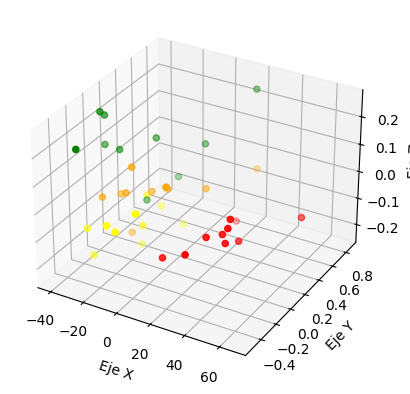

In [27]:
plot_features3d(reduced)